# Plot a comparison of sea level rates from different sources for the global ocean and the Dutch coast

To improve:
- Read altimetry from budget instead of recomputing
- Better separate VLM from other processes

In [51]:
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd
import xarray as xr

from scipy.stats import linregress
from matplotlib.lines import Line2D
import matplotlib.markers as markers

import regionmask

In [2]:
# For higher resolution images on retina display screens
import matplotlib_inline.backend_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('retina')


In [55]:
data_dir = "~/Data/"

data_walker22 = f"{data_dir}Walker2022/DataPaper/"
data_gam = "~/Projects/NetherlandsSeaLevelAcceleration/outputs/"
data_duacs = f"{data_dir}/duacs_cmems/"
data_signal = "~/Projects/KNMIClimateScenarios2021-2023/2021_KNMIsignal_21/Content/Klimaatsignaal2021_SeaLevel_MethodAndReproducibility/output_data/"

ar6_dir = '~/Projects/Project_ProbSLR/Data_Proj/Data_AR6/AR6_Projections/'
data_ar6 = f'{ar6_dir}Regional/medium_confidence/'

# Specify colors
rgb_red = '#d52b1e' #(213, 43, 30)

## Read and check data from Walker et al. 2022

In [4]:
def read_w22(site_name, data_choice):
    
    if data_choice == "height":
        nb_rows_skip = 2
        skipfooter = 108
        
    elif data_choice == "rate":
        nb_rows_skip = 116
        skipfooter = 0
        
    df = pd.read_csv(f"{data_walker22}siteplot-_TG+GSL+PX_TG+GSL+PX_GMML-2tsx3ss_lb-{site_name}-60y_denoised.tsv",
                  engine='python',
                  sep="\t",
                  skiprows=nb_rows_skip,
                  skipfooter=skipfooter)

    df.set_index("Year", inplace=True)
    df.index.rename("Time", inplace=True)
    
    return df

In [5]:
den_df = read_w22("Denmark-HoBugt", "rate")
sco1_df = read_w22("Scotland-KyleofTongue", "rate")
sco2_df = read_w22("Scotland-LochLaxford", "rate")


In [6]:
multi_sites_df = pd.concat([den_df["mm/y"].rename("Denmark"), 
                            sco1_df["mm/y"].rename("Scotland1"), 
                            sco2_df["mm/y"].rename("Scotland2")], axis=1 )

multi_sites_df["Average"] = multi_sites_df.mean(axis=1)

multi_sites_df["AverageNoGIA"] = multi_sites_df["Average"] - multi_sites_df["Average"].loc[0:1700].mean()

<AxesSubplot: xlabel='Time'>

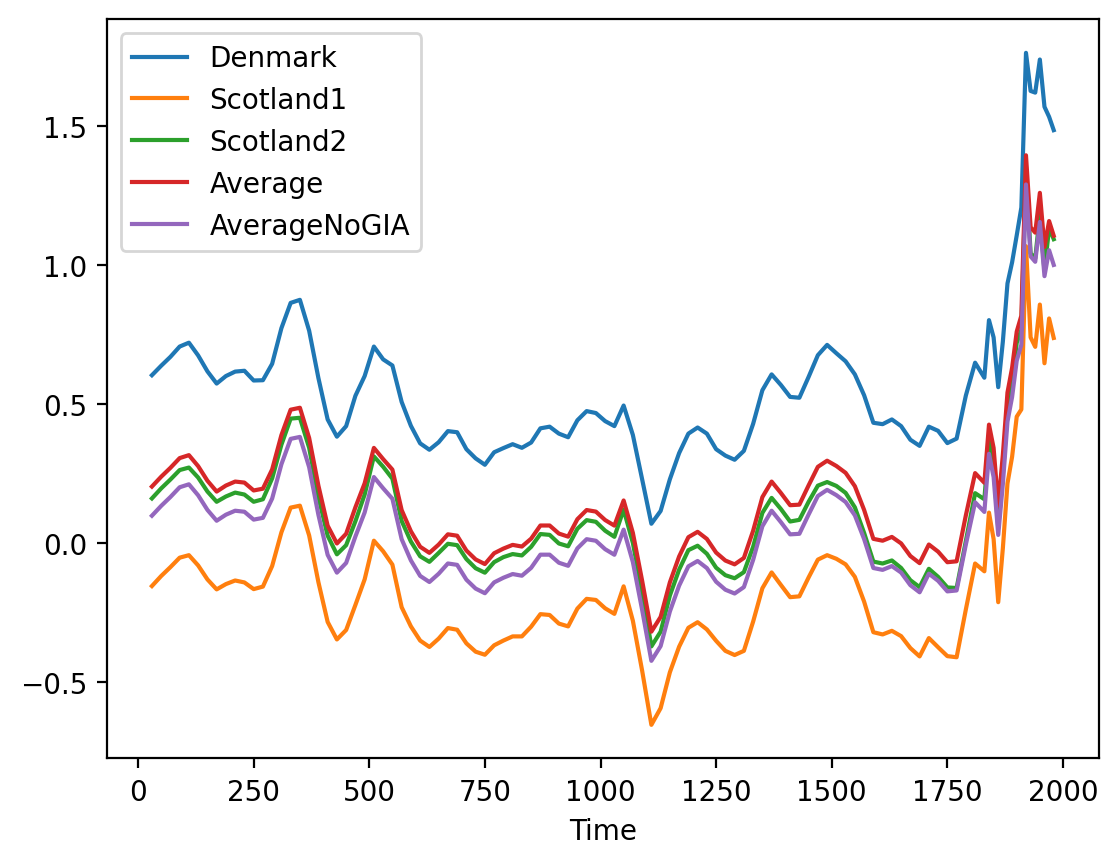

In [7]:
multi_sites_df.plot()

<AxesSubplot: xlabel='Time'>

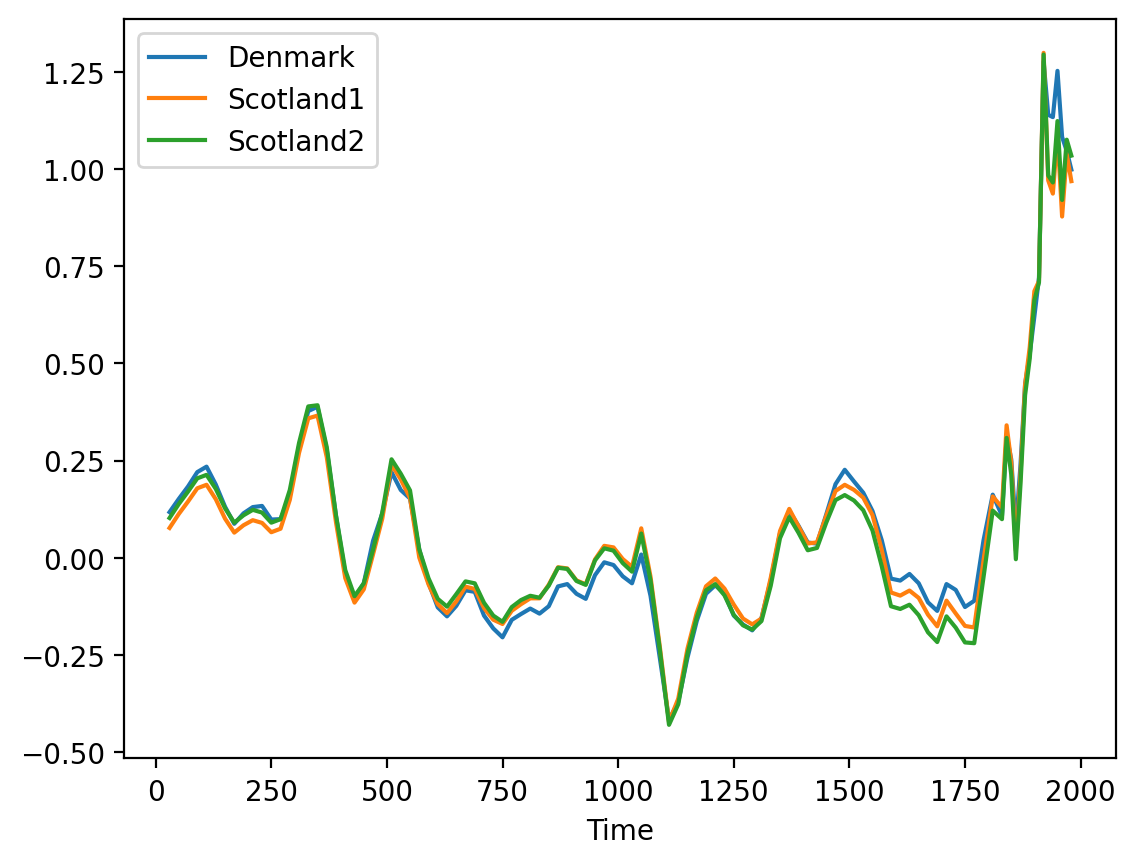

In [8]:
(multi_sites_df.iloc[:,:3] - multi_sites_df.iloc[:,:3].loc[0:1700].mean()).plot()

## Read data from Keizer et al.

In [9]:
#rates_na = pd.read_csv(f'{data_gam}rates_NearestPointAverage.csv')
rates_q_na = pd.read_csv(f'{data_gam}rates_quantiles_NearestPointAverage.csv')
rates_q_na.set_index("time", inplace=True)

rates_q_na = rates_q_na-0.37 # Remove GIA

In [10]:
rates_q_na

,0.05,0.17,0.5,0.83,0.95
time,,,,,
1890,NaN,NaN,NaN,NaN,NaN
1891,0.628876,0.920391,1.323111,1.725831,2.017346
1892,0.627312,0.918430,1.320601,1.722771,2.013889
1893,0.626114,0.916288,1.317156,1.718024,2.008198
1894,0.627264,0.915708,1.314184,1.712660,2.001104
...,...,...,...,...,...
2016,2.005162,2.276656,2.651716,3.026777,3.298271
2017,1.995719,2.270145,2.649257,3.028369,3.302795
2018,1.989716,2.266004,2.647686,3.029368,3.305656


<AxesSubplot: title={'center': 'Keizer et al.'}, xlabel='time'>

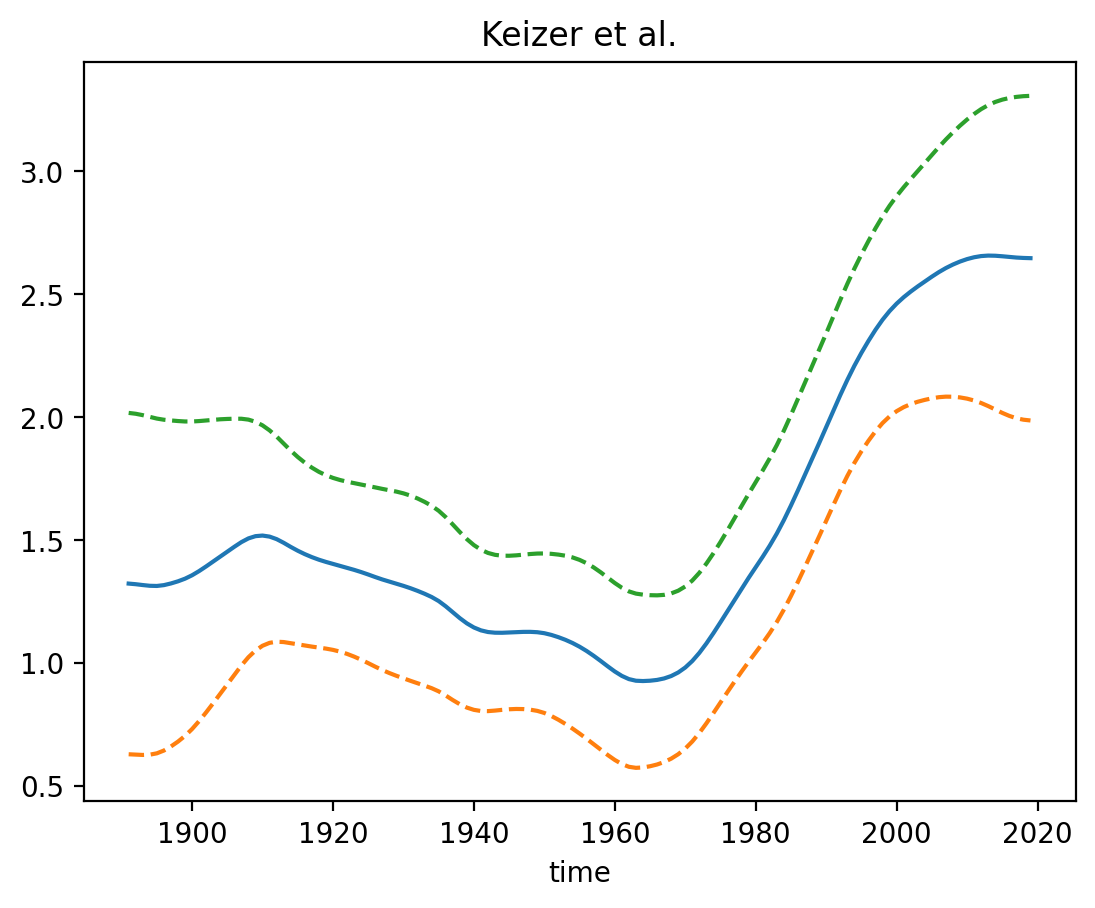

In [11]:
rates_q_na['0.5'].plot(title="Keizer et al.")
rates_q_na['0.05'].plot(linestyle='dashed')
rates_q_na['0.95'].plot(linestyle='dashed')


## Read altimetry data and compute linear trend for the Dutch coast

In [12]:
# Use the usual region to compute the altimetry signal on
NL = np.array([[2.5, 53], [3.3, 51.5], [4.25, 52.25], [4.75, 53.3], [5.5, 53.6], [7, 53.75], [7, 55], [4, 54.5]])
NLregion = regionmask.Regions([NL], names=['NL'], abbrevs=['NL'])

In [13]:
def rotate_longitude(ds, name_lon):

    ds = ds.assign_coords({name_lon:(((ds[name_lon] + 180 ) % 360) - 180)})
    ds = ds.sortby(ds[name_lon])

    return ds

In [14]:
duacs_ds = xr.open_mfdataset(f'{data_duacs}cmems_obs-sl_glo_phy-ssh_my_allsat-l4-duacs-0.25deg_P1M-m_*.nc').load()

duacs_ds = rotate_longitude(duacs_ds, 'longitude')
duacs_ds['sla'] = duacs_ds.sla*1000 # Convert from meter to mm

duacs_y_ds = duacs_ds.groupby('time.year').mean()

In [15]:
# Define the mask
mask_alti = NLregion.mask_3D(duacs_y_ds.longitude, duacs_y_ds.latitude)

duacs_y_m_ds = duacs_y_ds.where(mask_alti).sel(region=0)

In [16]:
weights = np.cos(np.deg2rad(duacs_y_m_ds.latitude))

alti_reg_avg = duacs_y_m_ds.weighted(weights).mean(dim=("latitude", "longitude"))

In [17]:
alti_df = pd.DataFrame(data=alti_reg_avg.sla, index=alti_reg_avg.year)
alti_df = alti_df.rename(columns={0:'Average'})
alti_df.index = alti_df.index+0.5

In [18]:
def linear_trend(se, acc=1):
    """Returns the linear trend and its standard error given a pandas series as input"""
    
    lin_trend = linregress(se.index, se)
    print(f'Linear trend [mm/y] for period {str(se.index[0])}-{se.index[-1]} and '+
          'standard error')
    print(f'{round(lin_trend.slope,acc)}, {round(lin_trend.stderr,acc)}')
    
    return lin_trend

In [19]:
alti_rate = linear_trend(alti_df["Average"])

Linear trend [mm/y] for period 1993.5-2021.5 and standard error
3.2, 0.6


## Read klimaatsignaal'21 projections and compute rates

In [20]:
signal_df = pd.read_csv(f"{data_signal}DataKlimaatsignaal21_SeaLevel_2100_ref_period_1995_2014.csv")
signal_df.set_index("time", inplace=True)

signal_df = signal_df*10 # Convert all values from cm to mm

scen = "ssp245"

In [21]:
signal_50pc_rate = linear_trend(signal_df.loc[2006:2026][f"{scen}_50pc"])

Linear trend [mm/y] for period 2006-2026 and standard error
4.9, 0.1


In [22]:
signal_5pc_rate = linear_trend(signal_df.loc[2006:2026][f"{scen}_5pc"])

Linear trend [mm/y] for period 2006-2026 and standard error
3.0, 0.1


In [23]:
signal_95pc_rate = linear_trend(signal_df.loc[2006:2026][f"{scen}_95pc"])

Linear trend [mm/y] for period 2006-2026 and standard error
7.8, 0.1


Remove the vertical land motion

In [24]:
signal_5pc_rate = signal_5pc_rate.slope - 0.45
signal_50pc_rate = signal_50pc_rate.slope - 0.45
signal_95pc_rate = signal_95pc_rate.slope - 0.45

## Read KNMI23 and compute rates

In [25]:
Projects_dir = '/Users/dewilebars/Projects/'
ProbSLR_dir = f'{Projects_dir}Project_ProbSLR/SLProj/'

proj_data_dir = f'{ProbSLR_dir}/outputs/KNMI23/'

KNMI23_ssp245 = xr.open_dataset(f'{proj_data_dir}SeaLevelPerc_KNMI23_ssp245_v10.nc')
KNMI23_ssp245 = KNMI23_ssp245.perc_ts

In [26]:
# Select and convert to mm
KNMI23_ssp245_s = KNMI23_ssp245.sel(proc='Total', time=slice(1995.5,2021.5))*10
#KNMI23_ssp245_s = KNMI23_ssp245.sel(proc='Total', time=slice(2010.5,2030.5))*10

In [27]:
KNMI23_50pc_rate = linear_trend(KNMI23_ssp245_s.sel(percentiles='50').to_dataframe()['perc_ts'])

Linear trend [mm/y] for period 1995.5-2021.5 and standard error
3.6, 0.1


In [28]:
KNMI23_5pc_rate = linear_trend(KNMI23_ssp245_s.sel(percentiles='5').to_dataframe()['perc_ts'])

Linear trend [mm/y] for period 1995.5-2021.5 and standard error
2.2, 0.1


In [29]:
KNMI23_95pc_rate = linear_trend(KNMI23_ssp245_s.sel(percentiles='95').to_dataframe()['perc_ts'])

Linear trend [mm/y] for period 1995.5-2021.5 and standard error
4.9, 0.1


Remove vertical land motion

In [30]:
KNMI23_50pc_rate_gia = linear_trend(KNMI23_ssp245.sel(percentiles='50', proc='GIA', time=slice(2006,2026)).to_dataframe()['perc_ts']*10)

Linear trend [mm/y] for period 2006.5-2025.5 and standard error
0.4, 0.0


In [31]:
KNMI23_5pc_rate = KNMI23_5pc_rate.slope - KNMI23_50pc_rate_gia.slope
KNMI23_50pc_rate = KNMI23_50pc_rate.slope - KNMI23_50pc_rate_gia.slope
KNMI23_95pc_rate = KNMI23_95pc_rate.slope - KNMI23_50pc_rate_gia.slope

In [32]:
KNMI23_50pc_rate_gia.slope

0.37

## Read rates from AR6

In [33]:
ar6_26_ds = xr.open_dataset(f'{data_ar6}ssp126/total_ssp126_medium_confidence_rates.nc')
ar6_45_ds = xr.open_dataset(f'{data_ar6}ssp245/total_ssp245_medium_confidence_rates.nc')
ar6_85_ds = xr.open_dataset(f'{data_ar6}ssp585/total_ssp585_medium_confidence_rates.nc')

ar6_45_lm_ds = xr.open_dataset(f'{data_ar6}ssp245/verticallandmotion_ssp245_medium_confidence_rates.nc')

In [34]:
ar6_45_mas = ar6_45_ds.sel(locations=9, quantiles=0.5, years=2020)
ar6_45_del = ar6_45_ds.sel(locations=24, quantiles=0.5, years=2020)

ar6_45_mas_lm_ds = ar6_45_lm_ds.sel(locations=9, quantiles=0.5, years=2020)
ar6_45_del_lm_ds = ar6_45_lm_ds.sel(locations=24, quantiles=0.5, years=2020)

In [35]:
ar6_45_mas.sea_level_change_rate.values.item()

4.599999904632568

In [36]:
ar6_45_del.sea_level_change_rate.values

array(4.8, dtype=float32)

In [37]:
ar6_45_mas_lm_ds.sea_level_change_rate.values

array(0.3, dtype=float32)

In [38]:
ar6_45_del_lm_ds.sea_level_change_rate.values

array(0.3, dtype=float32)

In [39]:
def prep_ar6_rate(scen, quantile):
    """Prepare AR6 rates for the Dutch coast.
    Average the two locations Maasluis and Delfzijl.
    Remove the vertical land motion"""
    
    ds = xr.open_dataset(f'{data_ar6}{scen}/total_{scen}_medium_confidence_rates.nc')
    vlm_ds = xr.open_dataset(f'{data_ar6}{scen}/verticallandmotion_{scen}_medium_confidence_rates.nc')
    
    mas_ds = ds.sel(locations=9, quantiles=quantile, years=2020)
    del_ds = ds.sel(locations=24, quantiles=quantile, years=2020)

    mas_lm_ds = ar6_45_lm_ds.sel(locations=9, quantiles=quantile, years=2020)
    del_lm_ds = ar6_45_lm_ds.sel(locations=24, quantiles=quantile, years=2020)

    rate = (mas_ds.sea_level_change_rate.values.item() - 
            mas_lm_ds.sea_level_change_rate.values.item() +
            del_ds.sea_level_change_rate.values.item() -
            del_lm_ds.sea_level_change_rate.values.item()
           )/2
    
    return rate

In [40]:
ar6_5pc_rate = prep_ar6_rate("ssp245", 0.05)
ar6_50pc_rate = prep_ar6_rate("ssp245", 0.5)
ar6_95pc_rate = prep_ar6_rate("ssp245", 0.95)

ar6_5pc_rate, ar6_50pc_rate, ar6_95pc_rate

(0.9500000216066837, 4.400000035762787, 8.4500000923872)

## Plot the results

(1850.0, 2030.0)

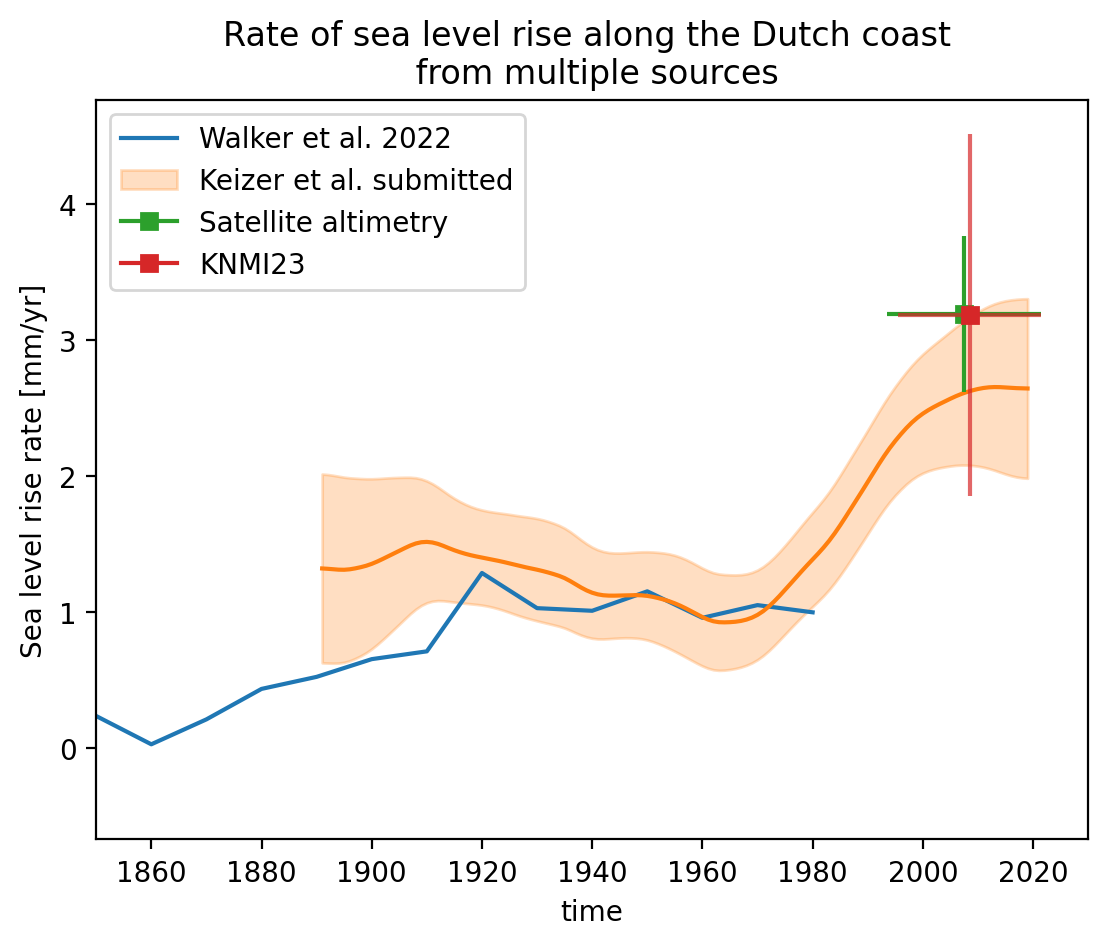

In [41]:
fig, ax = plt.subplots(1)

# Palaeo proxy
multi_sites_df["AverageNoGIA"].plot(ax=ax, label="Walker et al. 2022")

# Tide gauges
rates_q_na['0.5'].plot(ax=ax, color="tab:orange", label="")
alpha_val = 0.25

ax.fill_between(rates_q_na.index, 
                rates_q_na['0.05'], 
                rates_q_na['0.95'], 
                color='tab:orange',
                alpha=alpha_val,
                label='Keizer et al. submitted')

# Satellite altimetry
central_time  = (alti_df.index[-1] + alti_df.index[0])/2
ax.plot(central_time, alti_rate.slope, marker='s', color="tab:green", label="Satellite altimetry")
ax.vlines(x=central_time, 
           ymin=alti_rate.slope-alti_rate.stderr, 
           ymax=alti_rate.slope+alti_rate.stderr, 
           color="tab:green")

ax.hlines(alti_rate.slope, 
          alti_df.index[0], 
          alti_df.index[-1], 
          color="tab:green")


# # Klimaatsignaal
# ax.plot(2016, signal_50pc_rate, marker='s', color="tab:red", label="Climate signal 2021")
# ax.vlines(x=2016, 
#            ymin=signal_5pc_rate, 
#            ymax=signal_95pc_rate, 
#            color="tab:red")

# KNMI23
alk = 0.7
central_time = (KNMI23_ssp245_s.time[-1].data.item()+
                KNMI23_ssp245_s.time[0].data.item())/2
ax.plot(central_time, KNMI23_50pc_rate, marker='s', color="tab:red", 
        label="KNMI23")

ax.vlines(x=central_time, 
          ymin=KNMI23_5pc_rate, 
          ymax=KNMI23_95pc_rate, 
          color="tab:red",
          alpha=alk)

ax.hlines(KNMI23_50pc_rate, 
          KNMI23_ssp245_s.time[0].data.item(), 
          KNMI23_ssp245_s.time[-1].data.item(), 
          color="tab:red",
          alpha=alk)

# # AR6
# ax.plot(2020, ar6_50pc_rate, marker='s', color="tab:purple", label="AR6")
# ax.vlines(x=2020, 
#           ymin=ar6_5pc_rate, 
#           ymax=ar6_95pc_rate, 
#           color="tab:purple")


plt.title("Rate of sea level rise along the Dutch coast \n from multiple sources")
ax.set_ylabel("Sea level rise rate [mm/yr]")
plt.legend(loc="upper left")

#plt.xlim(1850, 2030)
#plt.xlim(1200, 2030)
plt.xlim(1850, 2030)

#plt.savefig("SeaLevelRates_DutchCoast_zoom_OnlyData.pdf", dpi=150)

### Figure brochure

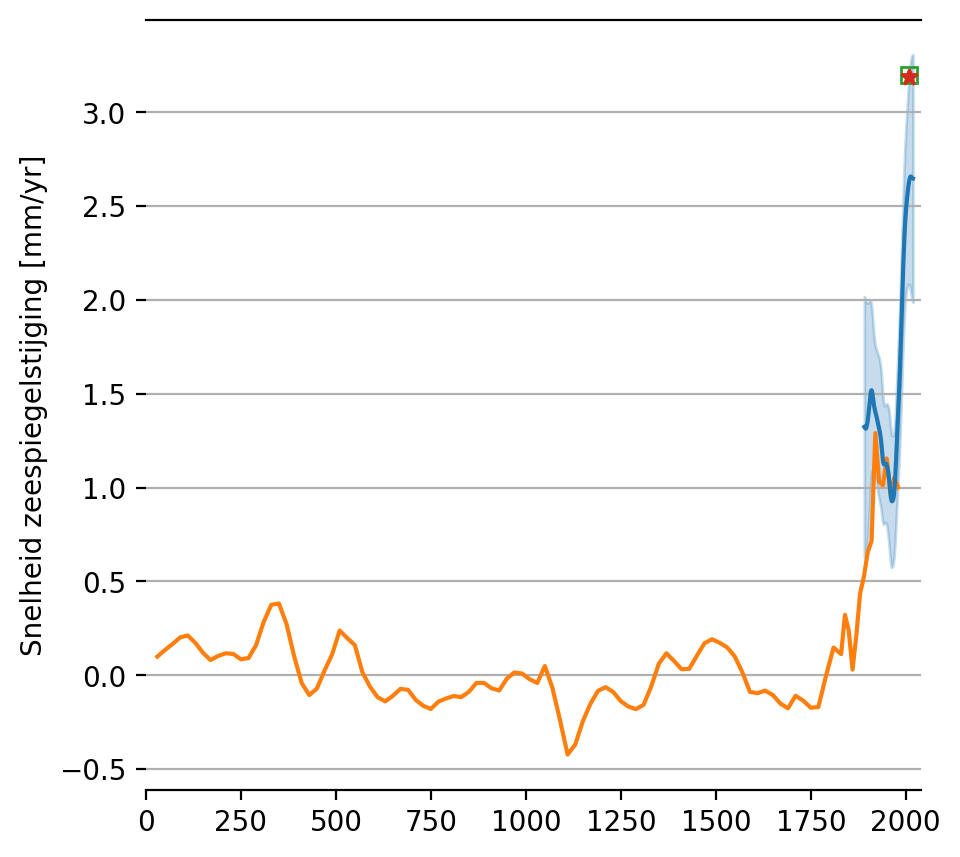

In [60]:
fig, ax = plt.subplots(figsize=[5, 5])

# Palaeo proxy
multi_sites_df["AverageNoGIA"].plot(ax=ax, label="Paleo proxy", color="tab:orange")

# Tide gauges
rates_q_na['0.5'].plot(ax=ax, color="tab:blue", label="")
alpha_val = 0.25

ax.fill_between(rates_q_na.index, 
                rates_q_na['0.05'], 
                rates_q_na['0.95'], 
                color='tab:blue',
                alpha=alpha_val,
                label='Hoofdgetijdestations')

# Satellite altimetry
central_time  = (alti_df.index[-1] + alti_df.index[0])/2
marker = markers.MarkerStyle(marker='s', fillstyle = 'none')
ax.plot(central_time, alti_rate.slope, marker=marker, color="tab:green", label="Satellietmetingen")

# KNMI23
central_time = (KNMI23_ssp245_s.time[-1].data.item()+
                KNMI23_ssp245_s.time[0].data.item())/2
ax.plot(central_time, KNMI23_50pc_rate, marker='*', color=rgb_red, 
        label="KNMI23")


# Adjust the legend
handles, labels = ax.get_legend_handles_labels()
handles[1] = (Line2D([], [], color='tab:blue'), handles[1])
ax.legend(handles, labels)

ax.set_xlabel("")
ax.set_ylabel("Snelheid zeespiegelstijging [mm/yr]")

plt.xlim(0, 2040);

# Hide the left and right spines
ax.spines[['left', 'right']].set_visible(False)
ax.grid(axis='y')

plt.savefig("figures/SeaLevelRates_DutchCoast_Brochure.pdf", dpi=150)

#ax.get_legend().remove()
#plt.savefig("figures/SeaLevelRates_DutchCoast_Brochure_nolegend.pdf", dpi=150)

### Figure scientific report

In [43]:
def plot_rates(multi_sites_df, rates_q_na, alti_df, KNMI23_ssp245_s, ax):
    
    # Palaeo proxy
    multi_sites_df["AverageNoGIA"].plot(ax=ax, label="Paleo proxies")

    # Tide gauges
    rates_q_na['0.5'].plot(ax=ax, color="tab:orange", label="")
    alpha_val = 0.25

    ax.fill_between(rates_q_na.index, 
                    rates_q_na['0.05'], 
                    rates_q_na['0.95'], 
                    color='tab:orange',
                    alpha=alpha_val,
                    label='Tide gauges')

    # Satellite altimetry
    central_time  = (alti_df.index[-1] + alti_df.index[0])/2
    ax.plot(central_time, alti_rate.slope, marker='o', color="tab:green", label="Satellite altimetry")
    ax.vlines(x=central_time, 
               ymin=alti_rate.slope-alti_rate.stderr, 
               ymax=alti_rate.slope+alti_rate.stderr, 
               color="tab:green")

    ax.hlines(alti_rate.slope, 
              alti_df.index[0], 
              alti_df.index[-1], 
              color="tab:green")


    # KNMI23
    alk = 0.7
    
    central_time = (KNMI23_ssp245_s.time[-1].data.item()+
                    KNMI23_ssp245_s.time[0].data.item())/2
    ax.plot(central_time, KNMI23_50pc_rate, marker='*', color="tab:red", 
            label="KNMI23 scenario", alpha=alk)

    ax.vlines(x=central_time, 
              ymin=KNMI23_5pc_rate, 
              ymax=KNMI23_95pc_rate, 
              color="tab:red",
              alpha=alk)

    ax.hlines(KNMI23_50pc_rate, 
              KNMI23_ssp245_s.time[0].data.item(), 
              KNMI23_ssp245_s.time[-1].data.item(), 
              color="tab:red",
              alpha=alk)
    ax.set_xlabel("Time [years]")
    
    return ax

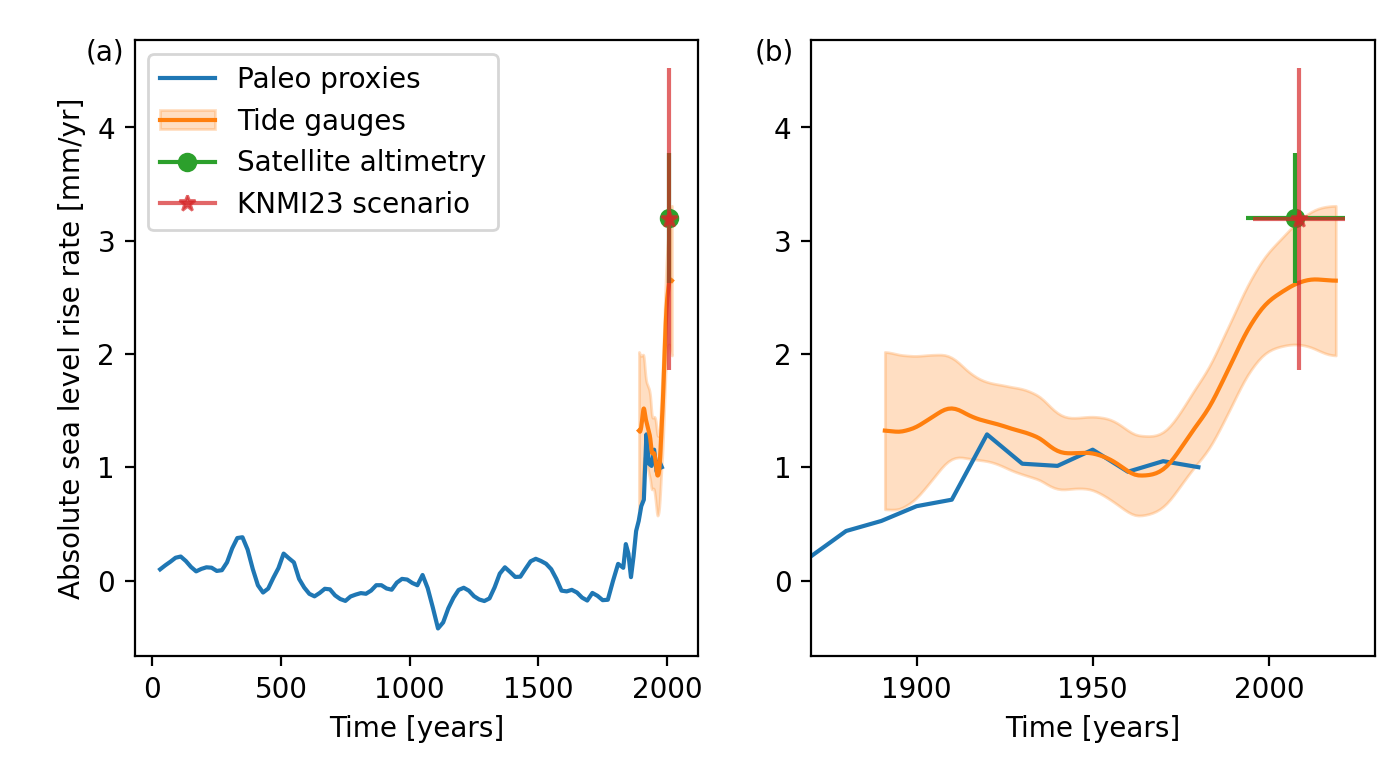

In [44]:
fig, axes = plt.subplots(ncols=2, figsize=[8, 4])

axes[0] = plot_rates(multi_sites_df, rates_q_na, alti_df, KNMI23_ssp245_s, axes[0])
axes[1] = plot_rates(multi_sites_df, rates_q_na, alti_df, KNMI23_ssp245_s, axes[1])

axes[0].set_ylabel("Absolute sea level rise rate [mm/yr]")

axes[0].legend(loc="upper left")

# Adjust the legend
handles, labels = axes[0].get_legend_handles_labels()
handles[1] = (Line2D([], [], color='tab:orange'), handles[1])
axes[0].legend(handles, labels)

axes[1].set_xlim(1870, 2030)

axes[0].text(0.05, 1.78, '(a)', horizontalalignment='center', verticalalignment='center', transform=ax.transAxes)
axes[0].text(1.4, 1.78, '(b)', horizontalalignment='center', verticalalignment='center', transform=ax.transAxes)

#plt.tight_layout()

plt.savefig("./figures/SeaLevelRates_DutchCoast.pdf", dpi=150)